In [31]:
# Web Scraping
import requests
from bs4 import BeautifulSoup

In [32]:
symbols = []
        
# Fetch the HTML content of the page
response = requests.get("https://etfdb.com/compare/market-cap/")

# Parse the HTML content
soup = BeautifulSoup(response.content, "html.parser")

# Find the table
table = soup.find('table')

# Find all rows in the table
rows = table.find_all('tr')

for row in rows:
    # Find all td elements in the row with attribute data-th="Symbol"
    tds = row.find_all('td', {'data-th': 'Symbol'})
    
    for td in tds:
        # Extract and store the symbol
        a_tag = td.find('a')
        if a_tag:
            symbols.append(a_tag.text.strip())

symbols[:10] # Return the first 10 symbols

['SPY', 'IVV', 'VOO', 'VTI', 'QQQ', 'VEA', 'VTV', 'IEFA', 'VUG', 'BND']

In [33]:
import pandas as pd
import yfinance as yf
import sys # For logging

In [34]:
prices = pd.DataFrame()
for i, symbol in enumerate(symbols):
    sys.stdout.write(f"\rDoing symbol: {symbol}, Progress: {i + 1}/{len(symbols)}")
    prices[symbol] = yf.download(symbol, start='2018-01-01', progress=False)['Close']

prices.head()

Doing symbol: EMB, Progress: 100/100

,SPY,IVV,VOO,VTI,QQQ,VEA,VTV,IEFA,VUG,BND,...,SPDW,EFV,VXF,EEM,VOE,VONG,BIV,VHT,MGK,EMB
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,268.769989,270.850006,247.089996,138.220001,158.490005,45.250000,106.650002,66.570000,142.250000,81.339996,...,31.950001,55.689999,112.709999,48.009998,112.120003,34.827499,83.559998,156.059998,112.669998,116.400002
2018-01-03,270.470001,272.420013,248.559998,139.020004,160.029999,45.529999,107.059998,67.010002,143.580002,81.410004,...,32.150002,55.919998,112.959999,48.470001,112.570000,35.154999,83.650002,157.610001,113.690002,116.349998
2018-01-04,271.609985,273.600006,249.649994,139.550003,160.309998,45.939999,107.680000,67.669998,143.970001,81.370003,...,32.439999,56.520000,113.250000,48.709999,113.000000,35.294998,83.650002,157.649994,113.970001,116.650002
2018-01-05,273.420013,275.329987,251.250000,140.369995,161.919998,46.160000,108.209999,68.019997,145.179993,81.260002,...,32.630001,56.889999,113.650002,49.130001,113.430000,35.612499,83.540001,158.889999,114.980003,116.720001
2018-01-08,273.920013,275.940002,251.770004,140.690002,162.550003,46.139999,108.320000,67.970001,145.649994,81.269997,...,32.590000,56.860001,113.980003,49.130001,113.830002,35.715000,83.500000,158.130005,115.320000,116.510002


In [35]:
import numpy as np

In [36]:
data = {
    "mean_all_returns": [],
    "std_all_returns": [],
    "mean_120d_returns": []
}

for column in prices.columns: # Iterate over prices to preprocess the data
    returns = np.log(prices[column] / prices[column].shift(1))
    data['mean_all_returns'].append(returns.mean())
    data['std_all_returns'].append(returns.std())
    data['mean_120d_returns'].append(returns.iloc[:120].mean())

df_an = pd.DataFrame(data, index=prices.columns)
df_an.dropna(inplace=True) # Delete the ETFs that don't have at least 120 trading days

df_an.head()

,mean_all_returns,std_all_returns,mean_120d_returns
SPY,0.000374,0.012982,0.000185
IVV,0.000372,0.013147,0.000216
VOO,0.000374,0.013065,0.000218
VTI,0.000352,0.013233,0.000253
QQQ,0.000625,0.015849,0.000848


In [37]:
# Remove outliers
for i in range(len(df_an) - 1):
    for col in df_an.columns:
        if df_an[col].iloc[i] > df_an[col].mean() + 3 * df_an[col].std():
            print(df_an.index[i])
            df_an.drop(df_an.index[i], inplace=True)
        elif df_an[col].iloc[i] < df_an[col].mean() - 3 * df_an[col].std():
            print(df_an.index[i])
            df_an.drop(df_an.index[i], inplace=True)

TQQQ


In [38]:
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.pyplot as plt

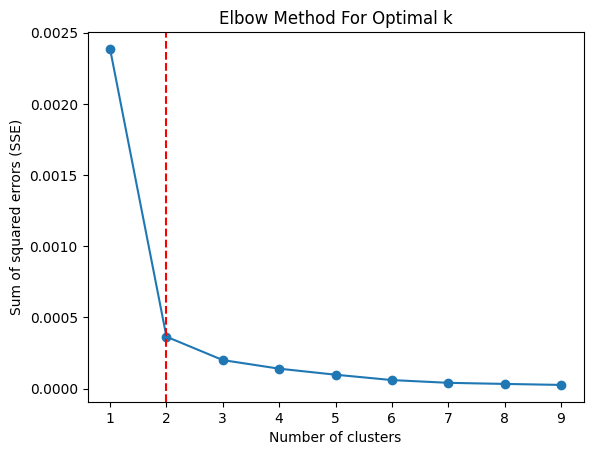

In [39]:
# Finding the optimal number of clusters using the elbow method
sse = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(df_an)
    sse.append(kmeans.inertia_)

# Determine the elbow point using KneeLocator
knee_locator = KneeLocator(range(1, 10), sse, curve='convex', direction='decreasing')
optimal_clusters = knee_locator.elbow

# Plotting the SSE for each k value
plt.figure()
plt.plot(range(1, 10), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared errors (SSE)')
plt.title('Elbow Method For Optimal k')
plt.axvline(x=optimal_clusters, color='red', linestyle='--')
plt.show()

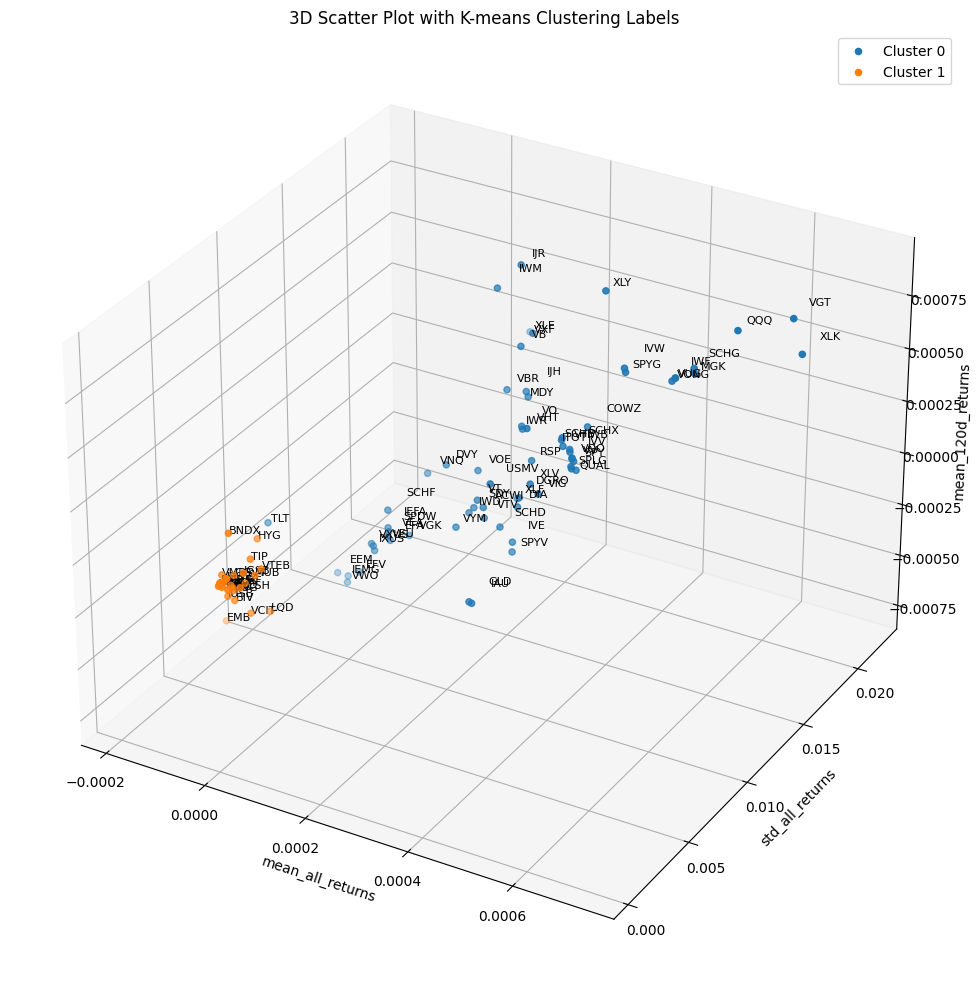

In [40]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=optimal_clusters, n_init=10)
kmeans.fit(df_an)

# Assuming 'kmeans' contains your fitted KMeans model with labels
labels = kmeans.labels_

# Create a 3D scatter plot
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(projection='3d')

# Extract the three features from the DataFrame
feature1 = df_an['mean_all_returns']
feature2 = df_an['std_all_returns']
feature3 = df_an['mean_120d_returns']

# Plot each point with a different color based on the K-means label and add row names
for i, label in enumerate(set(labels)):
    ax.scatter(feature1[labels == label], feature2[labels == label], feature3[labels == label], label=f'Cluster {label}')
    for j, row in enumerate(df_an.index[labels == label]):
        ax.text(feature1[labels == label][j], feature2[labels == label][j] + np.random.uniform(0, feature2[labels == label].min() * .2), feature3[labels == label][j], row, fontsize=8)

# Set labels and title
ax.set_xlabel('mean_all_returns')
ax.set_ylabel('std_all_returns')
ax.set_zlabel('mean_120d_returns')
plt.title('3D Scatter Plot with K-means Clustering Labels')

# Show the plot
plt.tight_layout()
plt.legend()
plt.show()